# Input

In [3]:
print('loading train...', flush=True, end='')

input_path = '../DL_model/dataset/preprocess4/input2/'
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']


welch_path = '../DL_model/dataset/preprocess4/welch/' 
x_test_welch = np.load(welch_path+'x_test.npz', allow_pickle=True)['arr_0']
y_test_welch = np.load(welch_path+'y_test.npz')['arr_0']
print('done', flush=True)


print('x_test.shape:', x_test.shape)
print('x_test welch.shape:', x_test_welch.shape)

loading train...done
x_test.shape: (8795, 5000, 2)
x_test welch.shape: (8792, 16, 128, 2)


## Welch test mask

In [4]:
import pickle

test_mask = pickle.load(open(welch_path+'test_mask_pacu','rb'))+pickle.load(open(welch_path+'test_mask_preop','rb'))

x_test_cnn = x_test[test_mask]
y_test_cnn = y_test[test_mask]

y_test_cnn_bin = y_test_cnn >= 4
y_test_welch_bin = y_test_welch >= 4


print('x_test cnn shape:', x_test_cnn.shape)
print('x_test welch shape:', x_test_welch.shape)

x_test cnn shape: (8792, 5000, 2)
x_test welch shape: (8792, 16, 128, 2)


## Class weight

### 2 class

In [ ]:
# binary classification
y_train_bin = y_train>=4
y_test_bin = y_test>=4
y_val_bin = y_val>=4


# 2 class에 대한 sample weight
train_w_samp2 = np.ones(shape=(len(y_train),))
train_w_samp2[y_train_bin==0]= len(y_train) / np.sum(y_train_bin)
train_w_samp2[y_train_bin!=0]= len(y_train) / np.sum(~y_train_bin)


print('train set')
print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_train) / np.sum(y_train_bin), len(y_train) / np.sum(~y_train_bin)))


# 2 class에 대한 sample weight
val_w_samp2 = np.ones(shape=(len(y_val),))
val_w_samp2[y_val_bin==0]= len(y_val) / np.sum(y_val_bin)
val_w_samp2[y_val_bin!=0]= len(y_val) / np.sum(~y_val_bin)

print('val set')
print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_val) / np.sum(y_val_bin), len(y_val) / np.sum(~y_val_bin)))

# 2 class에 대한 sample weight
test_w_samp2 = np.ones(shape=(len(y_test),))
test_w_samp2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin)
test_w_samp2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin)


print('test set')
print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin), len(y_test) / np.sum(~y_test_bin)))

### 3 class

In [6]:
# 3 class에 대한 sample weight
test_w_samp3 = np.ones(shape=(len(y_test),))

test_w_samp3[y_test<4]= len(y_test)/np.sum(y_test<4)
test_w_samp3[(y_test>=4)&(y_test<7)]= len(y_test)/np.sum((4<=y_test)&(y_test<7))
test_w_samp3[y_test>=7]= len(y_test)/np.sum(y_test>=7)

print('test set')
print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_test)/np.sum(y_test<4),len(y_test)/np.sum((y_test>=4)&(y_test<7)),len(y_test)/np.sum(y_test>=7)))

test set
sample weight for class 1: 2.62, class 2: 2.17, class 3: 6.36


## GPU Setting

In [5]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


## Best model

In [7]:
import os

def best_model_path(models_dir):
    roc_list = []
    model_list = os.listdir(models_dir)
    for f_model in model_list:
        if f_model[0:3]=='roc':
            roc_list.append(f_model[3:9])
        else:
            roc_list.append(0)


    roc_list = np.array(roc_list)
    return os.path.join(models_dir,model_list[np.argmax(roc_list)])

## Ensemble

In [19]:
from keras.layers import Average
from keras.models import Model

def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model
#ensemble_model = ensemble(models, model_input)

# Ensemble: ECG

## Input Loading

In [ ]:
print('loading train...', flush=True, end='')

input_path = '../DL_model/dataset/preprocess4/input2/'
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']


welch_path = '../DL_model/dataset/preprocess4/welch/' 
x_test_welch = np.load(welch_path+'x_test.npz', allow_pickle=True)['arr_0']
y_test_welch = np.load(welch_path+'y_test.npz')['arr_0']
print('done', flush=True)


print('x_test.shape:', x_test.shape)
print('x_test welch.shape:', x_test_welch.shape)

## Models loading

### 1D-CNN : Inception

In [ ]:
from keras.models import model_from_json
import os

models_dir = '1D-CNN_ECG/NRS>=4/Inception_8-20modules_sample-weight_3class'

load_path = best_model_path
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model_cnn = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
model_cnn.load_weights(load_weight_path)
print('done')

In [12]:
load_path

'1D-CNN_ECG+PPG/NRS>=4/1nception_8-20modules_sample-weight_3class/roc0.7662_prc0.8305_batch=256,nlayer=17,nfilters=16,c1layer256,k1=5x2,globalpool_opt=max,dropout=0.3,dnodes=0,dropout=0.1_acc0.80'

### LSTM

In [ ]:
from keras.models import model_from_json

models_dir = '1D-CNN_ECG+PPG'



load_path = 'output/preprocess3/input3-2_PPG+ECG/auroc0.7776_auprc0.7871_1D_CNN_model_bin_conv64_conv64_conv64_conv64_conv64_filter3x2_tanh_bn_maxpool2_globalmaxpool_dropout0.2_dense0_dropout0.3_batch1024_lr_0.001_kinit_kreg0acc0.75'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model_cnn = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
model_cnn.load_weights(load_weight_path)
print('done')

## Ensemble model

# Ensemble: PPG

## Input loading

In [60]:
print('loading train...', flush=True, end='')

input_path = '../DL_model/dataset/preprocess4/input2/PPG_100Hz/'
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']


welch_path = '../DL_model/dataset/preprocess4/welch/' 
x_test_welch = np.load(welch_path+'x_test.npz', allow_pickle=True)['arr_0']
y_test_welch = np.load(welch_path+'y_test.npz')['arr_0']
print('done', flush=True)


print('x_test.shape:', x_test.shape)
print('x_test welch.shape:', x_test_welch.shape)

loading train...done
x_test.shape: (8795, 2000, 1)
x_test welch.shape: (8792, 16, 128, 2)


In [61]:
import pickle

test_mask = pickle.load(open(welch_path+'test_mask_pacu','rb'))+pickle.load(open(welch_path+'test_mask_preop','rb'))

x_test_cnn = x_test[test_mask][:,:,0:1]
y_test_cnn = y_test[test_mask]
x_test_welch = x_test_welch[:,:,:,0]

y_test_cnn_bin = y_test_cnn >= 4
y_test_welch_bin = y_test_welch >= 4


print('x_test cnn shape:', x_test_cnn.shape)
print('x_test welch shape:', x_test_welch.shape)


# 3 class에 대한 sample weight
test_w_samp3 = np.ones(shape=(len(y_test),))

test_w_samp3[y_test<4]= len(y_test)/np.sum(y_test<4)
test_w_samp3[(y_test>=4)&(y_test<7)]= len(y_test)/np.sum((4<=y_test)&(y_test<7))
test_w_samp3[y_test>=7]= len(y_test)/np.sum(y_test>=7)

print('test set')
print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_test)/np.sum(y_test<4),len(y_test)/np.sum((y_test>=4)&(y_test<7)),len(y_test)/np.sum(y_test>=7)))

x_test cnn shape: (8792, 2000, 1)
x_test welch shape: (8792, 16, 128)
test set
sample weight for class 1: 2.62, class 2: 2.17, class 3: 6.36


## Models loading

### LSTM

In [50]:
from keras.models import model_from_json

models_dir = 'LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class'
load_path = best_model_path(models_dir)
print(load_path)
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model_lstm = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
model_lstm.load_weights(load_weight_path)
print('done')

LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class/roc0.7580_prc0.8281_gru_batch=512,unit16,unit64,unit128,dropout=0.5,dnodes=0,dropout=0,dnodes=0,dropout=0_acc0.78
loading model...done
loading weights...done


### CNN

In [53]:
from keras.models import model_from_json
import os

models_dir = '1D-CNN_PPG/NRS>=4_PPG100Hz/1D_CNN_5layers_sample-weighted_3class_lowess_filtered/manual'

load_path = best_model_path(models_dir)
print(load_path)
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model_cnn = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
model_cnn.load_weights(load_weight_path)
print('done')

1D-CNN_PPG/NRS>=4_PPG100Hz/1D_CNN_5layers_sample-weighted_3class_lowess_filtered/manual/roc0.7461_prc0.8220_batch=512,c1=128,c2=256,c3=0,filt1=7,filt2=3,filt3=0,str1=1,str2=1,str3=0,conv_double=True,globalpool=ave,dropout=0.4,dnodes=16,dropout=0.1_acc0.78
loading model...done
loading weights...done


## Ensemble

In [62]:
y_cnn = model_cnn.predict(x_test_cnn).flatten()
y_lstm = model_lstm.predict(x_test_welch).flatten()

# ensemble 모델에서 이들의 평균 이용
y_ens = (y_cnn+y_lstm)/2

## Evaluation

test set accuracy:0.77
test set AUROC: 0.7510967581342874
test set AUPRC: 0.8249460998580077


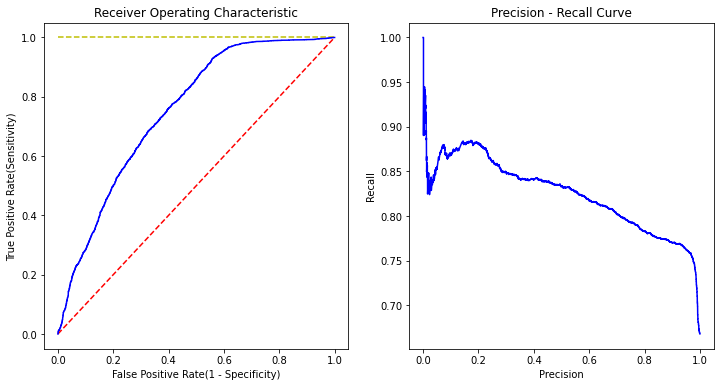

In [63]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


y_pred = y_ens
y_test_bin = y_test_cnn_bin
test_w_samp = test_w_samp3[test_mask]

### Classification
# Model Accuracy of test set
#model_y = y_pred>=0.5
#acc_val = np.mean(model_y==y_test_bin)
acc = metrics.Accuracy()
acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp)
acc_val = acc.result().numpy()
print('test set accuracy:{:.2f}'.format(acc_val))


# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight = test_w_samp)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight = test_w_samp)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC:', roc_auc)
print('test set AUPRC:', prc_auc)


# Adding evaluation results to file name
#test_path = 'output/preprocess4/welch/auroc{:.4f}_auprc{:.4f}_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
#os.rename(save_path, test_path)

# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

#plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)


# Ensemble: ECG+PPG+age,gender

## Input loading

In [1]:
print('loading train...', flush=True, end='')

input_path = '../DL_model/dataset/preprocess4/input2/'
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']


welch_path = '../DL_model/dataset/preprocess4/welch/' 
x_test_welch = np.load(welch_path+'x_test.npz', allow_pickle=True)['arr_0']
y_test_welch = np.load(welch_path+'y_test.npz')['arr_0']
print('done', flush=True)


print('x_test.shape:', x_test.shape)
print('x_test welch.shape:', x_test_welch.shape)

loading train...done
x_test.shape: (8795, 5000, 2)
x_test welch.shape: (8792, 16, 128, 2)


In [2]:
import pickle

test_mask = pickle.load(open(welch_path+'test_mask_pacu','rb'))+pickle.load(open(welch_path+'test_mask_preop','rb'))

x_test_cnn = x_test[test_mask]
y_test_cnn = y_test[test_mask]

y_test_cnn_bin = y_test_cnn >= 4
y_test_welch_bin = y_test_welch >= 4


print('x_test cnn shape:', x_test_cnn.shape)
print('x_test welch shape:', x_test_welch.shape)

x_test cnn shape: (8792, 5000, 2)
x_test welch shape: (8792, 16, 128, 2)


In [3]:
# 3 class에 대한 sample weight
test_w_samp3 = np.ones(shape=(len(y_test),))

test_w_samp3[y_test<4]= len(y_test)/np.sum(y_test<4)
test_w_samp3[(y_test>=4)&(y_test<7)]= len(y_test)/np.sum((4<=y_test)&(y_test<7))
test_w_samp3[y_test>=7]= len(y_test)/np.sum(y_test>=7)

print('test set')
print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_test)/np.sum(y_test<4),len(y_test)/np.sum((y_test>=4)&(y_test<7)),len(y_test)/np.sum(y_test>=7)))

test set
sample weight for class 1: 2.62, class 2: 2.17, class 3: 6.36


## Models loading

### ECG+age+gender CNN

In [4]:
age_test = np.load(input_path+'age_test.npz', allow_pickle=True)['arr_0']
gender_test = np.load(input_path+'gender_test.npz', allow_pickle=True)['arr_0']

age_test = age_test[test_mask]
gender_test = gender_test[test_mask]

agender_test = np.array([[age_test[i], gender_test[i]] for i in range(len(age_test))])


x_tests = [x_test_cnn[:,:,1:2], agender_test]

In [9]:
from keras.models import model_from_json
import os

models_dir = '1D-CNN_age+gender/ECG/1D_CNN_3layers_sample-weighted_3class_lowess_filtered'

load_path = best_model_path(models_dir)
print(load_path)
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model_cnn = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
model_cnn.load_weights(load_weight_path)
print('done')

1D-CNN_age+gender/ECG/1D_CNN_3layers_sample-weighted_3class_lowess_filtered/roc0.7725_prc0.8419_batch=512,c1=128,c2=32,c3=0,filt1=3,filt2=3,filt3=0,str1=1,str2=1,str3=0,conv_double=True,globalpool=ave,dropout=0.2,dnodes=0,dropout=0,dnodes=0,dropout=0_acc0.78
loading model...done
loading weights...done


### PPG LSTM

In [10]:
from keras.models import model_from_json

models_dir = 'LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class'
load_path = best_model_path(models_dir)
print(load_path)
#load_path = 'output/preprocess3/input3-2_PPG+ECG/auroc0.7776_auprc0.7871_1D_CNN_model_bin_conv64_conv64_conv64_conv64_conv64_filter3x2_tanh_bn_maxpool2_globalmaxpool_dropout0.2_dense0_dropout0.3_batch1024_lr_0.001_kinit_kreg0acc0.75'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model_lstm = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
model_lstm.load_weights(load_weight_path)
print('done')

LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class/roc0.7580_prc0.8281_gru_batch=512,unit16,unit64,unit128,dropout=0.5,dnodes=0,dropout=0,dnodes=0,dropout=0_acc0.78
loading model...done
loading weights...done


## Ensemble

In [11]:
#model_ens = ensemble([model_cnn, model_lstm], [x_tests, x_test_welch[:,:,:,0]])

y_cnn = model_cnn.predict(x_tests).flatten()
y_lstm = model_lstm.predict(x_test_welch[:,:,:,0]).flatten()

# ensemble 모델에서 이들의 평균 이용
y_ens = (y_cnn+y_lstm)/2

## Evaluation

test set accuracy:0.78
test set AUROC: 0.7831257885873636
test set AUPRC: 0.8510957156083211


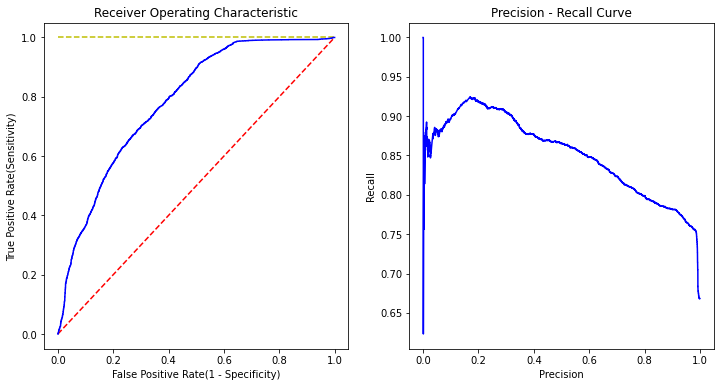

In [48]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


y_pred = y_ens
y_test_bin = y_test_cnn_bin
test_w_samp = test_w_samp3[test_mask]

### Classification
# Model Accuracy of test set
#model_y = y_pred>=0.5
#acc_val = np.mean(model_y==y_test_bin)
acc = metrics.Accuracy()
acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp)
acc_val = acc.result().numpy()
print('test set accuracy:{:.2f}'.format(acc_val))


# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight = test_w_samp)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight = test_w_samp)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC:', roc_auc)
print('test set AUPRC:', prc_auc)


# Adding evaluation results to file name
#test_path = 'output/preprocess4/welch/auroc{:.4f}_auprc{:.4f}_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
#os.rename(save_path, test_path)

# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

#plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)


test set accuracy:0.66
test set AUROC: 0.5936561929348905
test set AUPRC: 0.7343466022889066


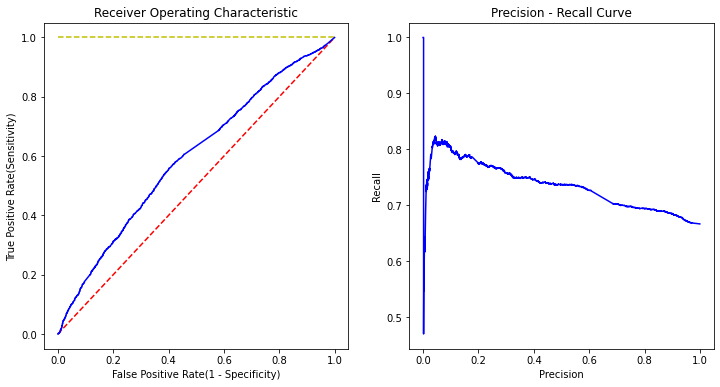

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


y_pred = y_lstm
y_test_bin = y_test_cnn_bin
test_w_samp = test_w_samp3[test_mask]

### Classification
# Model Accuracy of test set
#model_y = y_pred>=0.5
#acc_val = np.mean(model_y==y_test_bin)
acc = metrics.Accuracy()
acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp)
acc_val = acc.result().numpy()
print('test set accuracy:{:.2f}'.format(acc_val))


# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight = test_w_samp)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight = test_w_samp)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC:', roc_auc)
print('test set AUPRC:', prc_auc)


# Adding evaluation results to file name
#test_path = 'output/preprocess4/welch/auroc{:.4f}_auprc{:.4f}_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
#os.rename(save_path, test_path)

# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

#plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)
